# The Arab Spring: a highly broadcasted revolution

*By Robin Leurent, Sacha Leblanc, Alexis Dewaele and Matthieu Baud*

The « Arab Spring » is a historical period dating from the December 2010 until mid-2012 that saw the rise of many revolutions over the Islamic world, starting with Tunisia. As the influence of online media grows more and more every day, we would like to study the impact of these media on the spread of these revolutions across around 20 countries. To do this, we emit the hypothesis that the coverage of key events (such as riots, destitutions, etc…) are correlated to the start of revolutions of countries that are neighboring Tunisia. It would also be interesting to find out how the coverage done by government-owned media differs from independent media (e.g. blog posts, independent newspapers). We are also interested in studying whether media are consistent with the information they give out, according to media types (e.g. official media, blog posts, forum,…). We plan to research these topics by exploring the Spinn3r dataset which contains over 3,8 billion data points.

### Imports

In [138]:
import pickle
import csv
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
import wikipedia
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import numpy as np
import string
from numpy.linalg import norm
import os
import matplotlib.pyplot as plt
from googletrans import Translator
from datetime import date,datetime

In [117]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import *

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '6g'),
                                   ('spark.driver.memory','2g'),
                                   ('spark.driver.maxResultSize', '1G')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [118]:
spark

## The Data

For this project, we worked with the Spinn3r dataset, which consists of 1.6 TB of data. This is a massive amount of data, one that we cannot fully copy on our machines locally. Thus we decided to sample it so as to be able to work on it on our local machines since we are not allowed to work directly on the cluster.

In [119]:
data = spark.read.json("data/large_sample.json")

In [120]:
data.printSchema()

root
 |-- feed: struct (nullable = true)
 |    |-- channelUrl: string (nullable = true)
 |    |-- dateFound: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- lastPosted: string (nullable = true)
 |    |-- lastPublished: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- feedEntry: struct (nullable = true)
 |    |-- authorEmail: string (nullable = true)
 |    |-- authorName: string (nullable = true)
 |    |-- content: string (nullable = true)
 |    |-- dateFound: string (nullable = true)
 |    |-- identifier: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- lastPublished: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- permalinkEntry: struct (nullable = true)
 |    |-- authorEmail: string (nullable = true)
 |    |-- authorName: string (nullable = true)
 |    |-- content: string (nullable = true)
 |    |

As we can see, we can collect each column of the data in a Spark dataframe. From the schemas we know that we have a lot of redundant information between these columns such as the url or the language. The part of the data that interests us the most is the "feedEntry" column since it contains the content of the article/blogpost/... and the "source" column since it indicates if the article comes from a webblog, some social media, etc... Therefore we want to keep the publisherType information that is in the "source" column.

In [121]:
feed_entries = data.select(data.feedEntry.authorEmail.alias("authorEmail"),\
                          data.feedEntry.authorName.alias("authorName"),\
                          data.feedEntry.content.alias("content"),\
                          data.feedEntry.dateFound.alias("dateFound"),\
                          data.feedEntry.identifier.alias("identifier"),\
                          data.feedEntry.language.alias("language"),\
                          data.feedEntry.lastPublished.alias("lastPublished"),\
                          data.feedEntry.title.alias("title"),\
                          data.feedEntry.url.alias("url"),
                          data.source.publisherType.alias("publisherType"))

In [122]:
feed_entries.select("content").show()

+--------------------+
|             content|
+--------------------+
|<div>Awesome, loo...|
|<div>I'm hearing ...|
|<div><a href="htt...|
|<div>Didn't see t...|
|<div><div align="...|
|<div><!-- google_...|
|<div><b>The Girl ...|
|The latest Craft ...|
|<div>Can anyone g...|
|You may wish to f...|
|<div><font size="...|
|<div>I am thinkin...|
|<div>Ever since I...|
|<div>I just bough...|
|<div align="cente...|
|<div>1940's / 50'...|
|<div><!-- google_...|
|<div><div align="...|
|<div><div align="...|
|<a href="http://s...|
+--------------------+
only showing top 20 rows



Just from the previous cell we can see that the content of the articles/blogposts,etc... are not "clean" : there is still some HTML code in it that we need to clear.

In [123]:
@udf(StringType())
def clean_html(s):
    return BeautifulSoup(s).text

In [124]:
feed_entries = feed_entries.withColumn("cleaned_content", clean_html("content")).drop("content")

Some entries in our data contain empty content which is of no use to us, thus we decide to drop these rows.

In [125]:
feed_entries = feed_entries.filter(feed_entries["cleaned_content"] != "")

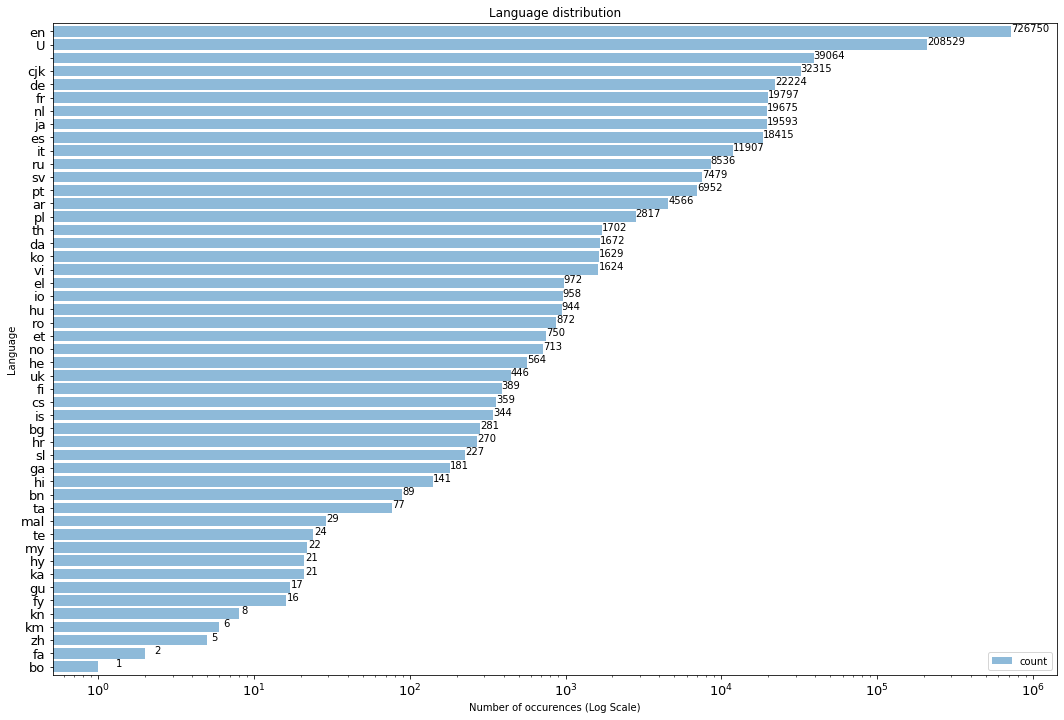

In [46]:
#langCount = feed_entries.groupBy("language").agg(count("*").alias("count")).orderBy("count").toPandas()
langCount = pd.read_pickle("langCount.pkl")
ax = langCount.plot(kind="barh", x="language", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

In [126]:
unknown = feed_entries.filter((feed_entries.language=='U') | (feed_entries.language == ''))

In [127]:
unknown.count()

247593

As we can see, we have a multitude of languages in our dataset. The language 'U' and ' ' correspond to unknown languages in the dataset so we use the langdetect library to find the correct language as they represent almost 20% of our dataset.

In [128]:
@udf('string')
def find_language(content):
    try :
        return detect(content)
    except Exception:
        return ''
    

In [129]:
unknown = unknown.withColumn('language',find_language('cleaned_content'))

In [130]:
corrected_feedEntries= feed_entries.filter((feed_entries.language!= 'U') & (feed_entries.language != '')).union(unknown)
corrected_feedEntries = corrected_feedEntries.filter((corrected_feedEntries.cleaned_content != '') & (corrected_feedEntries.language != ''))

We also notice that one of the language codes is "cjk" which regroups various languages, especially asian languages such as chinese, japanese or korean. Later in this notebook we need to do some translations, and since the Google Translation API doesn't recognize the code "cjk", we use the `langdetect` package to determine the correct language.

In [131]:
asian = corrected_feedEntries.filter((corrected_feedEntries.language=='cjk'))
asian = asian.withColumn('language',find_language('cleaned_content'))
corrected_feedEntries= corrected_feedEntries.filter(corrected_feedEntries.language != "cjk").union(asian)
corrected_feedEntries.cache()

DataFrame[authorEmail: string, authorName: string, dateFound: string, identifier: string, language: string, lastPublished: string, title: string, url: string, publisherType: string, cleaned_content: string]

Now we can plot the language distribution with the newly detected languages:

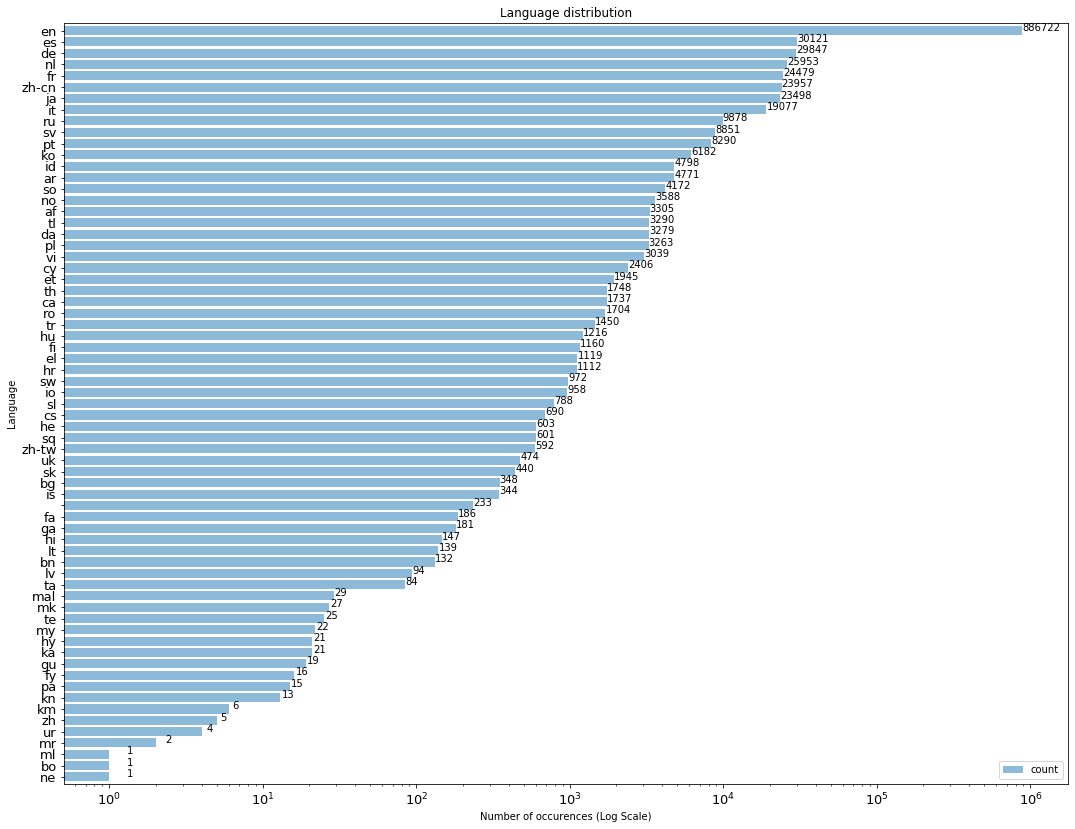

In [141]:
#correctedLangCount = corrected_feedEntries.groupBy("language").agg(count("*").alias("count")).orderBy("count").toPandas()
#correctedLangCount.to_pickle("correctedLangCount.pkl")
correctedLangCount = pd.read_pickle("correctedLangCount.pkl")
ax = correctedLangCount.plot(kind="barh", x="language", y="count", figsize=(18,14), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

We decided to keep only the european languages and the Arab one, in order to aswer our resarch question.


In [132]:
europe_lang = list(pd.read_csv("data/europeLang",header = None)[0])

In [133]:
@udf("boolean")
def filter_by_language(language):
    return language in europe_lang

In [134]:
corrected_feedEntries = corrected_feedEntries.filter(filter_by_language(corrected_feedEntries.language))

In [188]:
corrected_feedEntries.groupBy('language').count().orderBy('count').show(40)

+--------+------+
|language| count|
+--------+------+
|      ka|    21|
|      hy|    21|
|      mk|    29|
|      lv|    87|
|      lt|   142|
|      bg|   343|
|      is|   344|
|      sk|   441|
|      uk|   475|
|      sq|   592|
|      cs|   697|
|      sl|   772|
|      el|  1115|
|      hr|  1119|
|      fi|  1151|
|      hu|  1222|
|      tr|  1447|
|      ro|  1695|
|      ca|  1745|
|      et|  1931|
|      cy|  2378|
|      pl|  3266|
|      da|  3268|
|      no|  3502|
|      pt|  8296|
|      sv|  8864|
|      ru|  9881|
|      it| 19068|
|      fr| 24469|
|      nl| 25929|
|      de| 29822|
|      es| 30115|
|      en|886861|
+--------+------+



We also plotted the publisherType distribution. The publisherType attribute is the type of the entry (ex: Social media, blog post, mainstream news....)

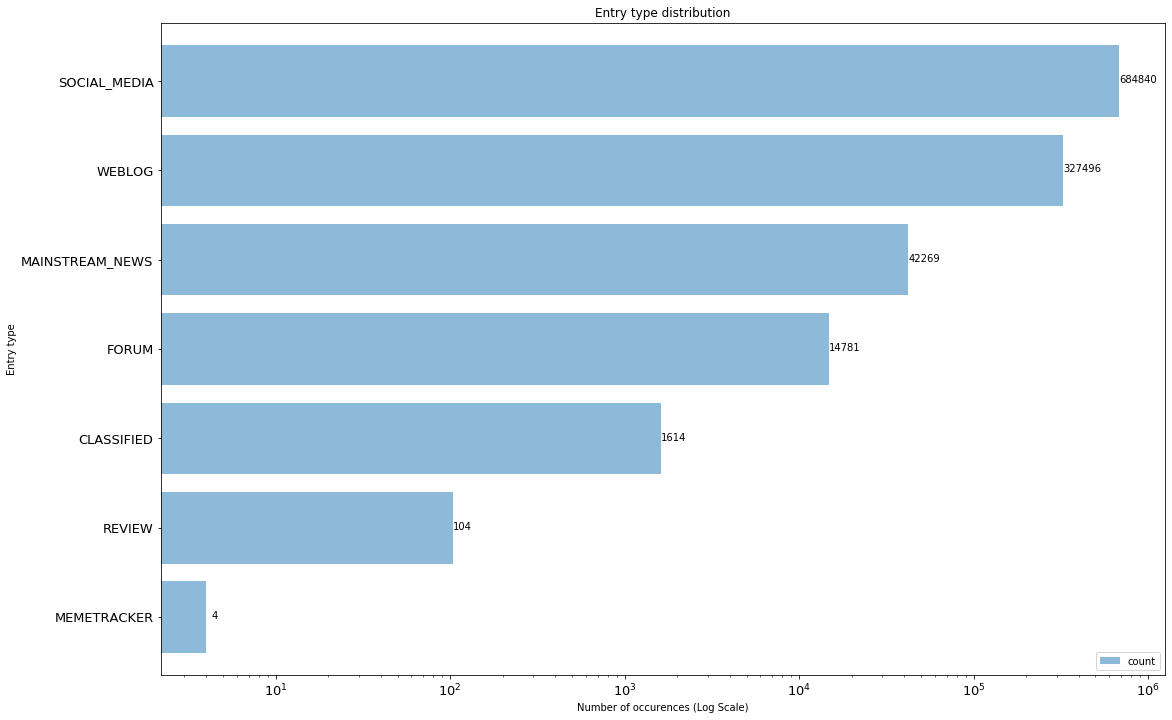

In [135]:
#pubType = corrected_feedEntries.groupBy("publisherType").agg(count("*").alias("count")).orderBy("count").toPandas()
pubType = pd.read_pickle("data/publisherType.pkl")
ax = pubType.plot(kind="barh", x="publisherType", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Entry type distribution")
for i in ax.patches:²
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

## Discerning an Arab Spring related entries

### Latent Semantic Analysis (LSA)

In this part, we implemented an LSA model in order to find if an entry was related to the Arab Spring or not. LSA extract principal concepts of a corpus, similarly to a PCA, using the SVD decomposition of a TFIDF matrix. It is then possible to compute the similarity between the corpus and a new document.

#### Utility functions

In [139]:
#Clean a text, removes all non english caracters, removes the end of line, and lowers the text
def clean(s):
    return ''.join([i if ord(i) < 128 else '' for i in s]).replace('\n', ' ').lower()

#Removes words from a query that are not in the tfidf model vocabulary
def remove_non_frequent_words(text):
    resultwords  = [x for x in text.split() if x in vectorizer.vocabulary_]
    return ' '.join(resultwords)

#Computes the tfidf vector for a given query
def to_tfidf_vector(query):
    query = remove_non_frequent_words(query.lower().translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))
    return  vectorizer.transform([query]).todense().tolist()[0]

# COmputes the cosine similarity between two vectors
def cos_sim(a,b):
    if(norm(a)==0):
        return 0
    return (np.dot(a, b)/(norm(a)*norm(b)))[0,0]


#Computation of similarity of the query to the relevant documents

#This function compute the average similarity
def average_computation(vector):
    return np.mean(all_sims(vector))

# This function returns all similarities
def all_sims(vector):
    sims = []
    for i in range(len(revolution_corpus)):
        sim = cos_sim(vector,vh_k[:,i])
        print("Document",doc_names[i],": ",sim)
        sims.append(sim)
    return sims

def compute_similarity(query):
    
    vector1 = to_tfidf_vector(query)
    
    index = np.argwhere(np.array(vector1) >0).squeeze()
    print("Words of the query in the vocabulary:")
    v = vectorizer.vocabulary_
    print([x for x in v if v[x] in index],'\n')
    
    final_query = np.array(vector1).dot(multiplier)
    return average_computation(final_query)

#### Corpus creation

We used wikipedia articles to create a revolution corpus of the arab spring in different countries, and a negative corpus unrelated to these events. 

In [6]:
Arab_Spring = clean(wikipedia.page("Arab Spring").content)
Egyptian_revolution = clean(wikipedia.page("Egyptian revolution of 2011").content)
Tunisian_revolution = clean(wikipedia.page("Tunisian Revolution").content)
Algerian_revolution = clean(wikipedia.page("2010–12 Algerian protests").content)
Moroccan_revolution = clean(wikipedia.page("2011–12 Moroccan protests").content)
Yemeni_Revolution = clean(wikipedia.page("Yemeni Revolution").content)


with open('data/nat_geo.txt', 'r') as file:
    nat_geo = file.read().replace('\n', '')
nat_geo = clean(nat_geo)

revolution_corpus = [Arab_Spring, Egyptian_revolution, Tunisian_revolution, Algerian_revolution, Moroccan_revolution,nat_geo,Yemeni_Revolution]


In [143]:
holiday = clean(wikipedia.page("Holiday").content)
japan_korea = clean(wikipedia.page("2019 Japan-South Korea trade dispute").content)
sport = clean(wikipedia.page("Sport").content)
hank =  clean(wikipedia.page("Hank Marino").content)
art = clean(wikipedia.page("Art").content)
IBM = clean(wikipedia.page("IBM").content)
meteo = clean(wikipedia.page("Weather Forecasting").content)
social_media = clean(wikipedia.page("Social Media").content)
negative_corpus = [holiday, japan_korea,sport,hank,art,IBM,social_media]

for i in range(150):
    os.system('clear')
    try:
        negative_corpus.append(clean(wikipedia.page(wikipedia.random()).content))
    except:
        #In case of an ambiguous page name, we just find a new one
        i = i -1
    
print("Done")

Done


In [57]:
doc_names = ["Arab Spring","Egyptian Revolution","Tunisian Revolution","Algerian Revolution","Morrocan Revolution","Nat Geo Article","Yemeni Revolution"]

In [33]:
corpus = revolution_corpus + negative_corpus
number_documents =  len(corpus)

In [36]:
stopWords = set(nltk.corpus.stopwords.words('english'))

#### Data cleaning and non frequent words removal

In [42]:
for i in range(len(corpus)):
    counter= CountVectorizer(analyzer = "word", stop_words=stopWords)
    V = counter.fit_transform([corpus[i]]).todense().tolist()[0]
    indices = np.argwhere(np.array(V)>6).squeeze()
    vocab = counter.vocabulary_
    words = [x for x in vocab if vocab[x] in indices and not x.isdigit()]
    
    frequent_words  = [x for x in corpus[i].split() if x in words]
    corpus[i] = ' '.join(frequent_words)

#### TFIDF 

In [43]:
vectorizer = TfidfVectorizer(analyzer ="word")
X = vectorizer.fit_transform(corpus).T

#### SVD Decomposition and principle components selection

In [59]:
u, s, vh = np.linalg.svd(X.todense())
print(s)

[1.72348071e+00 1.37028552e+00 1.27570033e+00 1.22108492e+00
 1.17677740e+00 1.13614030e+00 1.13093277e+00 1.13022699e+00
 1.12548675e+00 1.10398274e+00 1.09488978e+00 1.09403455e+00
 1.08504964e+00 1.06981046e+00 1.05382079e+00 1.04907457e+00
 1.04097608e+00 1.03138857e+00 1.02498261e+00 1.02059742e+00
 1.01866193e+00 1.01525020e+00 1.01269371e+00 1.00888592e+00
 1.00311513e+00 1.00203151e+00 1.00139814e+00 1.00086154e+00
 1.00057008e+00 1.00012380e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

In [62]:
# We keep only the principal components of the SVD decomposition
s = s[s>1.02]
dimension = len(s)

u_k = u[:,:dimension]
vh_k = vh[:dimension,:]

In [63]:
#Used in the function compute_similarity
multiplier = u_k.dot(np.linalg.inv(np.diag(s)))

In [64]:
content = corrected_feedEntries.filter(corrected_feedEntries.language == 'en').select("cleaned_content").collect()

We tried to tune is as much as possible, and we tried a lot of different ways to improve it, but unfortunately we were not able to have consistent and good results with this model. We have a lot of false negatives and false positives. For example, in the next cell we can see that documents that should be classified as Arab Spring related only get a 0.5/1 similarity which is clearly not enough.

In [67]:
i=0
for elem in content:
    for word in ['Tunisia','Tunis','tunisian','egypt','riots','protests']:
        if word in elem[0].split(' '):

            i += 1
            
            print("\n Average Similarity:",compute_similarity(elem[0]),'\n')
            break
print(i)

Words of the query in the vocabulary:
['protests', 'announced', 'like', 'charles', 'hall', 'magic'] 

Document Arab Spring :  0.45708392333221387
Document Egyptian Revolution :  0.6575691415739321
Document Tunisian Revolution :  0.8230690263111091
Document Algerian Revolution :  0.7912320944838005
Document Morrocan Revolution :  0.7473449666758039
Document Nat Geo Article :  0.6440489315514661
Document Yemeni Revolution :  0.7551217377597887

 Average Similarity: 0.6964956888125877 

Words of the query in the vocabulary:
['egyptian', 'egypt', 'class', 'better', 'friends', 'making', 'family', 'life'] 

Document Arab Spring :  0.8925615945790104
Document Egyptian Revolution :  0.8429062151258975
Document Tunisian Revolution :  0.47142479827230055
Document Algerian Revolution :  0.18197419596179956
Document Morrocan Revolution :  0.09197847115007193
Document Nat Geo Article :  0.5783595394617138
Document Yemeni Revolution :  0.44429314992896746

 Average Similarity: 0.5004997092113944 

W

In the other hand, some queries that should not be classified as Arab Spring related obtained extremely high scores. ( 0.9/1)

### Keyword Extraction

As this method was non conclusive, we decided to manualy extract keywords representing the Arab SPring, and to filter out alll entries having less than 3 keywords.

#### Keywords translation

This function was used in an external script to translate the keywords into all the european languages.

In [83]:
# With this function, we translate every keywords in the top languages
def keywords_translation(lang_list):
    keywords = list(pd.read_csv('keywords.csv',header = None)[0])
    translator = Translator()
    for language in lang_list:
            translations = translator.translate(keywords, dest=language)
            translated_keywords = []
            for tr in translations:
                translated_keywords.append(tr.text)
            with open("translated_keywords.csv", 'a') as f:
                writer = csv.writer(f,delimiter = ';')
                writer.writerow(translated_keywords)

In [146]:
keywords = pd.read_csv("data/translated_keywords.csv")

In [147]:
#Returns true if the word is related to the arab spring
@udf("boolean")
def filter_keywords(word, language):
    kw = list(keywords[language])
    return word in kw

#### Tokenize the content of the entries and stopwords removal

In [148]:
regexTokenizer = RegexTokenizer(inputCol="cleaned_content", outputCol="words", pattern="\\W")
entries = regexTokenizer.transform(corrected_feedEntries)

In [149]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered words")
entries = remover.transform(entries).drop("words")

#### FIltering the data to keep only Arab spring related entries

In [150]:
exploded_entries = entries.select("lastPublished","title","publisherType","language",
                                    explode(entries["filtered words"]).alias("word"))

In [151]:
# We filter out the non arab spring related words, and keep only the entries containing strictly more than 2 words
entries = exploded_entries.filter(filter_keywords(exploded_entries["word"], exploded_entries.language))

In [154]:
entries = entries.groupBy("lastPublished","title","publisherType", "language").agg(collect_set("word").alias("keywords"))

In [198]:
filtered_entries = entries.filter(size(entries.keywords) > 2)

In [199]:
filtered_entries.show()

+--------------------+--------------------+---------------+--------+--------------------+
|       lastPublished|               title|  publisherType|language|            keywords|
+--------------------+--------------------+---------------+--------+--------------------+
|                    |Egypt may find th...|         WEBLOG|      en|[islamist, sudan,...|
|2011-01-15T18:07:12Z|Arab activists ho...|MAINSTREAM_NEWS|      en|[uprising, arab, ...|
|2011-01-16T10:07:00Z|Tense calm return...|         WEBLOG|      en|[tunisia, arab, o...|
|2011-01-19T17:32:06Z|Tunisia’s Revolut...|         WEBLOG|      en|[tunisia, revolut...|
|2011-01-20T13:00:24Z|Freya Stark: Intr...|         WEBLOG|      en|[islamic, arab, war]|
|2011-01-20T17:45:00Z|Reviews of Atlas ...|         WEBLOG|      en|[tunisia, opposit...|
|2011-02-03T10:40:02Z|BusinessWeek: Oil...|         WEBLOG|      en|[egypt, yemen, pr...|
|2011-02-06T15:34:49Z|Bill Maher Calls ...|         WEBLOG|      en|[opposition, revo...|
|2011-02-0

In [200]:
# Tranfsormation of the date field from string to dateFormat
filtered_entries = filtered_entries.withColumn("lastPublished_dateFormat", to_date(filtered_entries.lastPublished, "yy-MM-dd"))

In [201]:
filtered_entries.write.json('data/filtered_entries.json')

In [223]:
filtered_entries = spark.read.json('data/filtered_entries.json')

### Visualization

#### Entry type distribution for the arab spring related entries

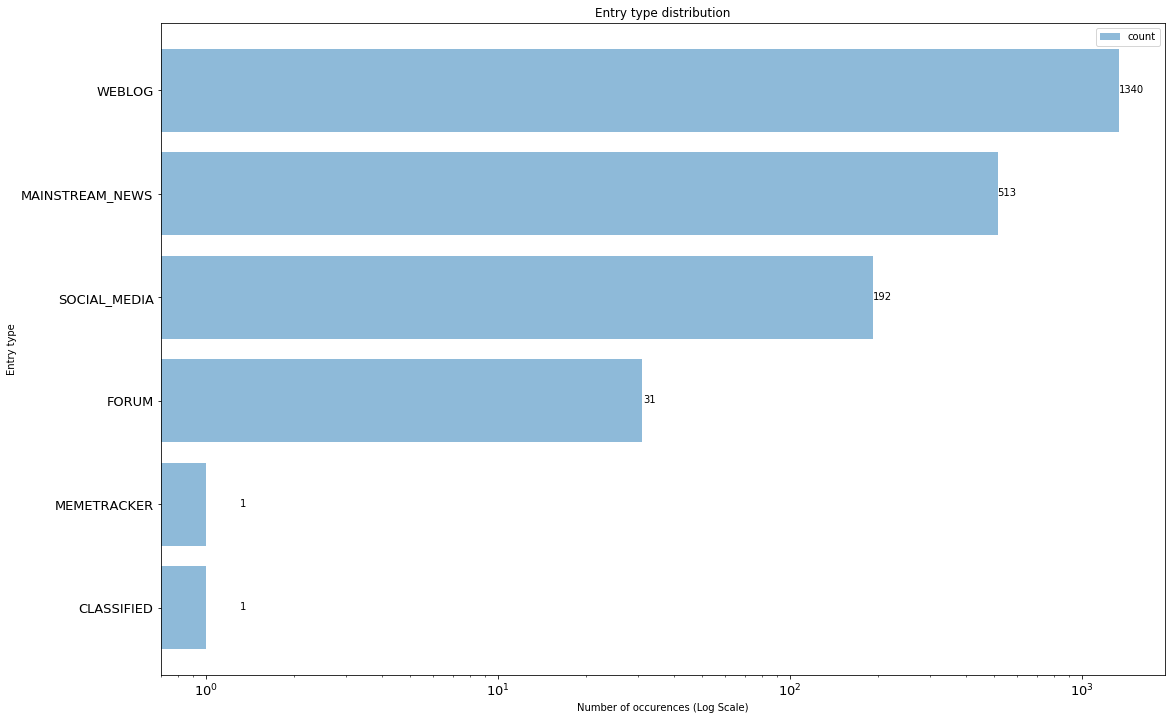

In [225]:
#pubType = filtered_entries.groupBy("publisherType").agg(count("*").alias("count")).orderBy("count").toPandas()
#pubType.to_pickle("pubType_after_filter.pkl")
pubType = pd.read_pickle("pubType_after_filter.pkl")
ax = pubType.plot(kind="barh", x="publisherType", y="count", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Entry type distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

#### Language distribution for the Arab spring related entries

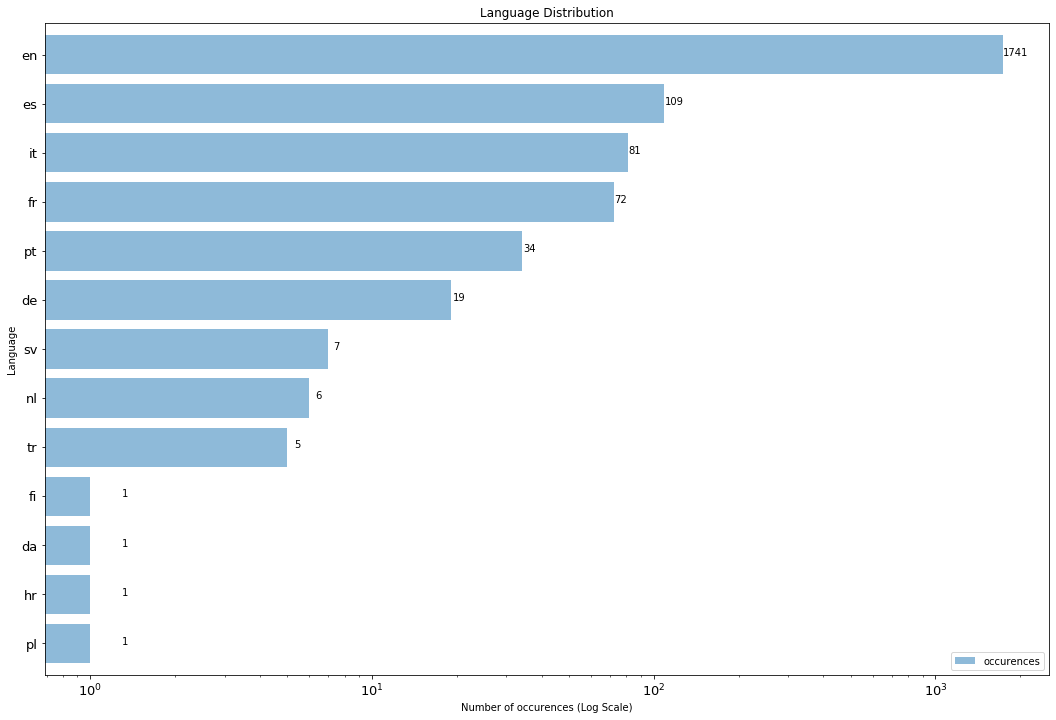

In [226]:
per_lang = filtered_entries.groupBy("language").agg(count("*").alias("occurences")).toPandas()
per_lang.to_pickle("AS_perLang.pkl")
#per_lang = pd.read_pickle("AS_perLang.pkl")
ax = per_lang.sort_values(by="occurences", ascending=True).plot(kind="barh", x="language", y="occurences", figsize=(18,12), alpha=0.5, logx=True, width=0.8, fontsize=13)
ax.set_ylabel("Language")
ax.set_xlabel("Number of occurences (Log Scale)")
plt.title("Language Distribution")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

We observe that we have a lot of missing languages, which is probably due to our small dataset (only 1.2 million entries over 380 millions) and the fact that some countries have a lot of their medias in english (such as Norway). We will need to find them with the urls and expand furthermore our dataset for the next milestone. 

We also notice no Arab entries, which is due to the arab grammar. Depending on where and what role in the sentence the word has, it will not be written the same way, which makes a keyword analysis almost impossible for non arab speakers. (which we are) 

#### Number of Arab Spring related entries per day

In [238]:
occurences = filtered_entries.groupBy("lastPublished_dateFormat").agg(count('*').alias("occurences")).dropna()

In [239]:
occurences_per_lang = filtered_entries.groupBy("lastPublished_dateFormat", "language").agg(count("*").alias("occurences"))

In [255]:
occurences_per_lang_pd = occurences_per_lang.toPandas().dropna()

Text(0.5, 1.0, 'Number of Arab Spring related entries per day')

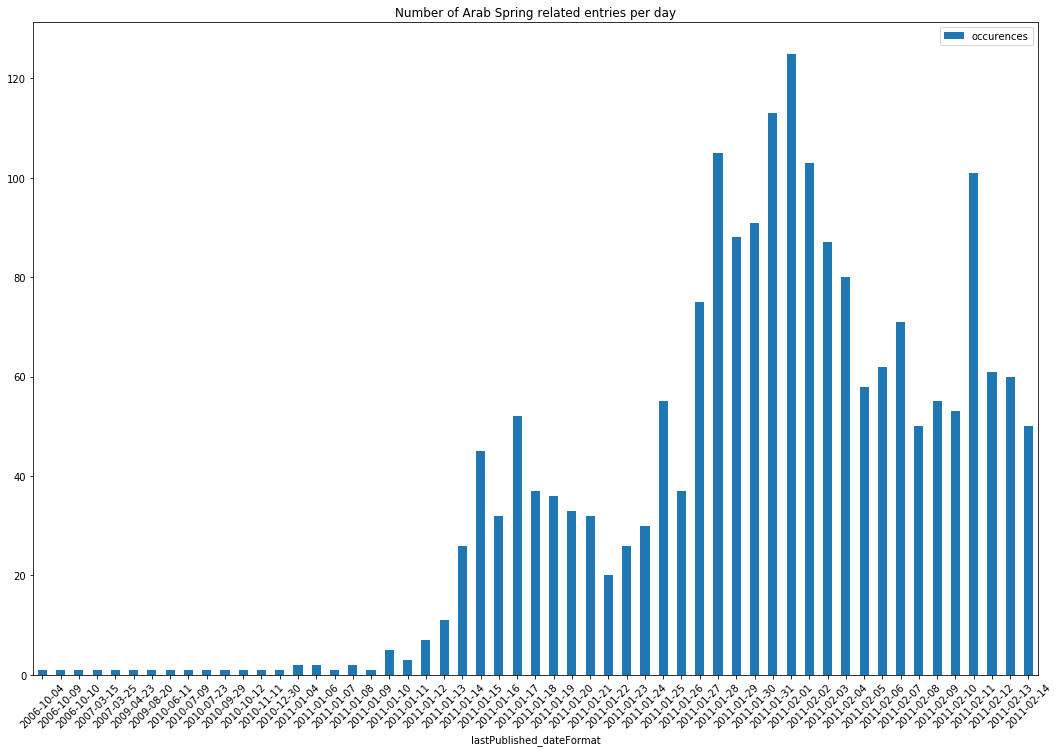

In [241]:
occurence_pd = occurences.toPandas()
#occurence_pd.to_pickle("occurences.pkl")
#occurence_pd = pd.read_pickle("occurences.pkl")
ax = occurence_pd.sort_values(by="lastPublished_dateFormat").plot(kind="bar", x="lastPublished_dateFormat", y="occurences",  figsize=(18,12), rot=45)
plt.title("Number of Arab Spring related entries per day")

#### Number of Arab Spring related entries per language and per day

<Figure size 1080x360 with 0 Axes>

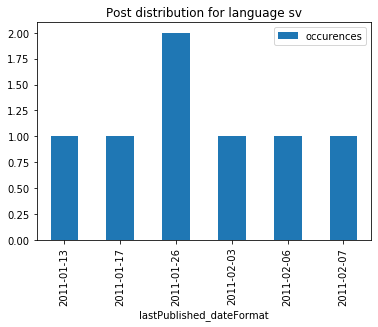

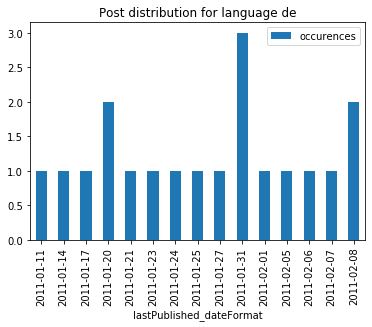

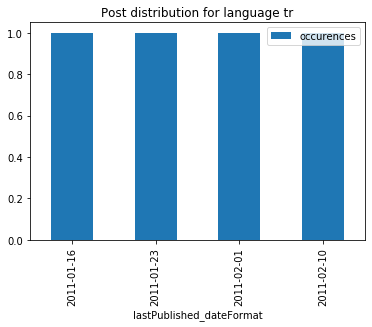

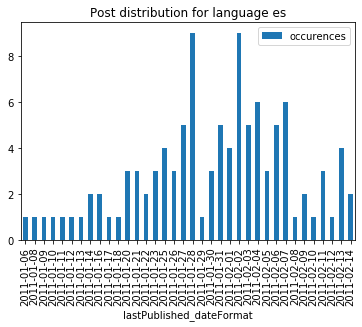

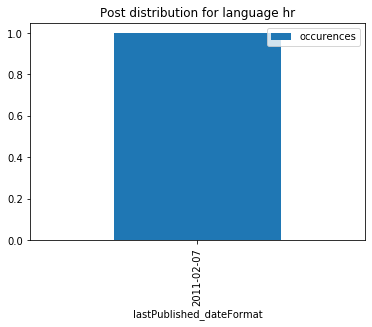

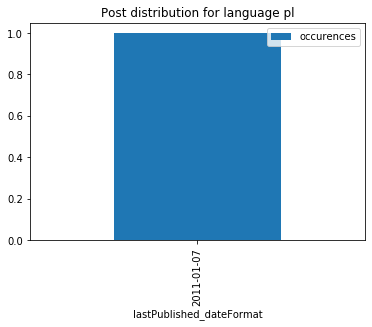

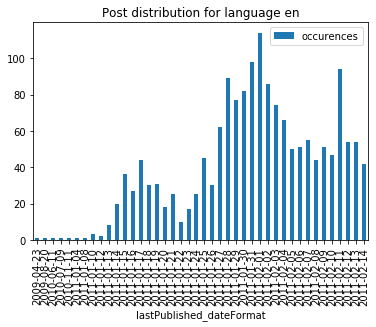

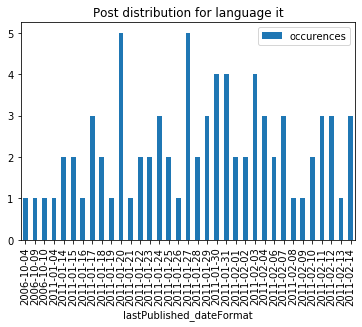

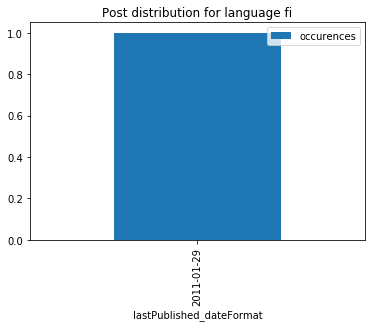

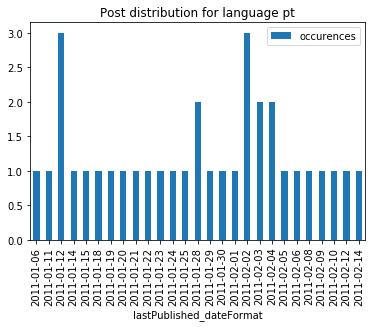

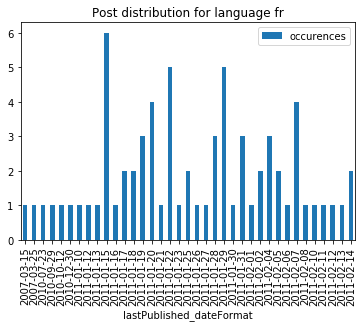

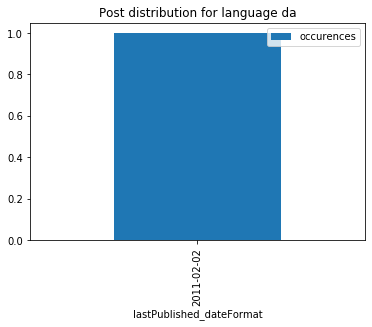

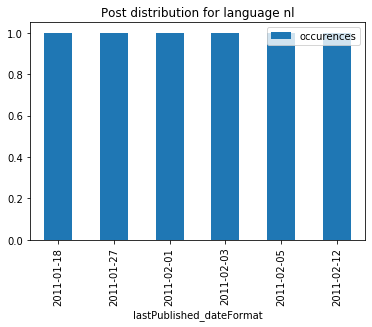

In [231]:
plt.figure(figsize = (15,5))
languages = list(set(occurences_per_lang_pd["language"]))
for l in languages:
    data_l = occurences_per_lang_pd[occurences_per_lang_pd["language"] == l].sort_values(by="lastPublished_dateFormat")
    ax = data_l.plot(kind="bar", x="lastPublished_dateFormat", y="occurences")
    plt.title("Post distribution for language " + l)

We observe that some languages have not enough data to be representative, such as the finnish plot which has only entries over one day. 

In [232]:
startDay = date(2010, 11, 15)

In [257]:
occurences_per_lang_pd["lastPublished_dateFormat"] = pd.to_datetime(occurences_per_lang_pd['lastPublished_dateFormat']).dt.date

In [258]:
arab_spring_events = {
    "2011-01-07": "Riots in Tunisia and Algeria",
    "2011-01-09": "Beginning of a referendum in South Sudan for autodetermination",
    "2011-01-10": "36 dead on the second day of the referendum in South Sudan",
    "2011-01-14": "Tunisian government overthrown",
    "2011-01-25": "Protestors gathered in Tahrir Square, Cairo, Egypt",
    "2011-02-11": "Egyptian president resigns",
    "2011-02-15": "Protests against the regime in Libya"
}

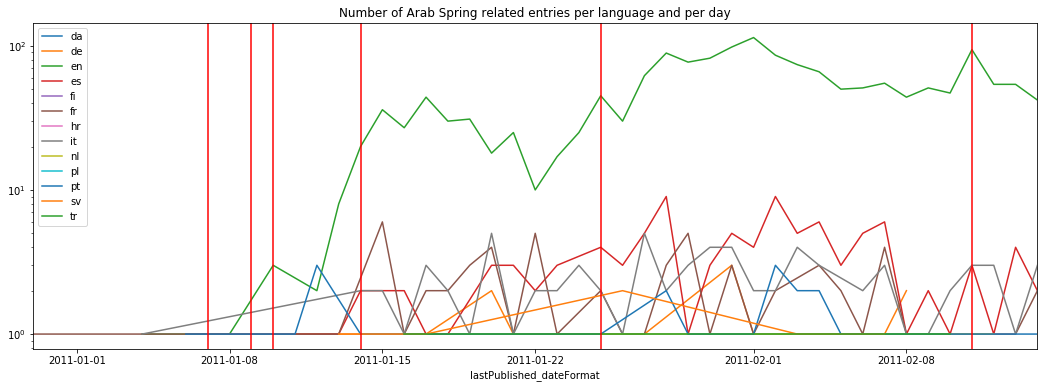

In [262]:
fig, ax = plt.subplots(figsize=(18,6))
for language, group in occurences_per_lang_pd[occurences_per_lang_pd["lastPublished_dateFormat"] > startDay].groupby("language"):
    group.plot(x="lastPublished_dateFormat", y="occurences", label=language, logy=True, ax=ax)

for event in arab_spring_events.keys():
    plt.axvline(x=datetime.strptime(event, "%Y-%m-%d").date(), color="red")

plt.title("Number of Arab Spring related entries per language and per day")
plt.show()


The red lines represent major events related to the Arab Spring during this period.

#### Arab Spring related entries compared to non related ones

In [271]:
pubtype = pd.read_pickle("pubType_after_filter.pkl")
alltype = pd.read_pickle("data/publisherType.pkl")

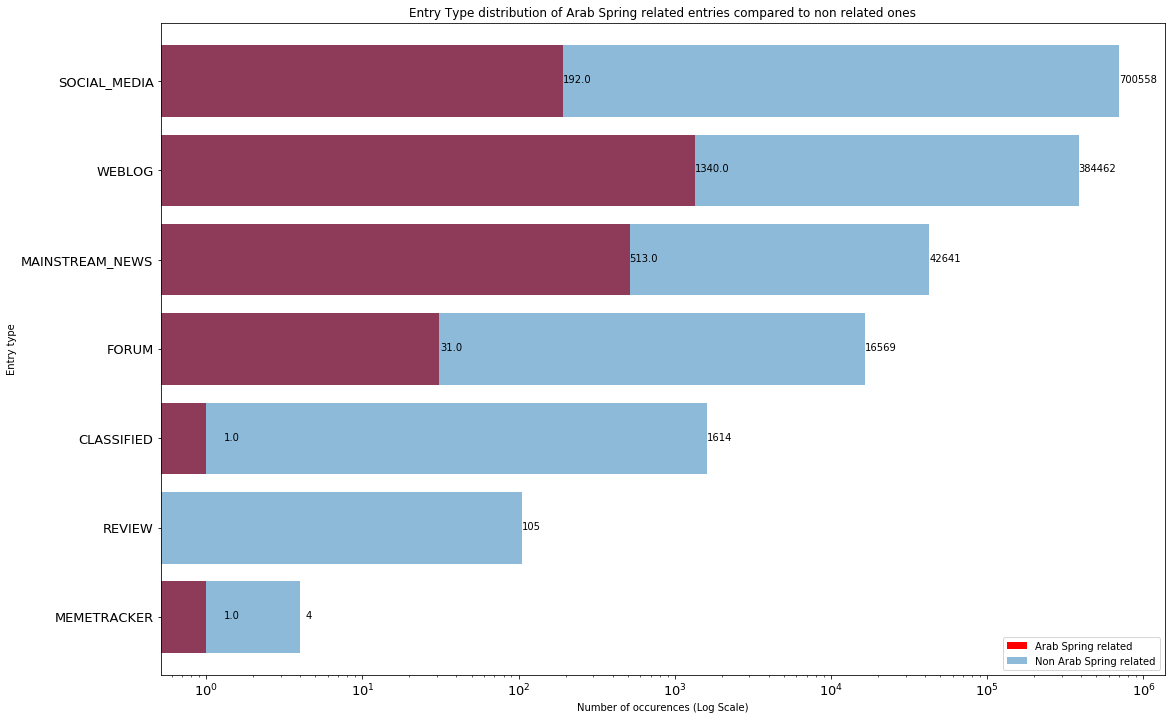

In [290]:
merged_df = allType.merge(pubType,on="publisherType",how = 'outer').sort_values('count_y')

fig = plt.figure()
ax = fig.add_subplot(111)
merged_df.plot(ax = ax,kind="barh", x="publisherType", y="count_x",color = 'red',figsize=(18,12), logx=True, width=0.8, fontsize=13,label = "Arab Spring related")
merged_df.plot(ax= ax,kind="barh", x= "publisherType", y="count_y", alpha=0.5, logx=True, width=0.8, fontsize=13,label = "Non Arab Spring related")


ax.set_ylabel("Entry type")
ax.set_xlabel("Number of occurences (Log Scale)")
for i in ax.patches:
    if(i.get_width() != 0):
        ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()))

plt.title("Entry Type distribution of Arab Spring related entries compared to non related ones");

## Conclusion

We are forced to drop our research questions that we submitted in the first milestone : 
* We wanted at first to do a separate analysis for each arabic country. It is unfortunately impossible to find the country of origin of the sources using their langauge since all arabic languages are classified as Arab, and Python libraries can't detect differences in dialects, i.e. we can't differentiate Egyptian from Tunisian,etc... Furthermore in these countries, the urls' extensions are almost always ".com" or ".net" and never the identifiable country extension such as ".dz, .eg,etc..." which makes it impossible to discover the true origin of the post using the URLs. Finally, for the content from web blogs and social media, people from all over the world can post on these websites and thus we can't find their country of origin.
* Second of all, publisher types such as social media will seldom use our defined keywords since they will rely on context to pass information, e.g. "Everyone in the streets tomorrow at 1pm!". Therefore we can't classify them as posts about the Arab Spring.
* Finally, it is very hard to extract keywords from languages using characters not from the latin alphabet such as Arabic. Indeed, in Arabic, the characters of a word will change depending on its position in the sentence, making it impossible to find our translated keyword. We can't translate Arabic posts in English either because of the limitations of the Google Translation API (our IP addresses are banned after a certain amount of characters translated)

This is why we shifted our research topic to : 
* What is the relationship between the different websites talking about the Arab Spring using a URL centered network?
* What is the proportion per country of Arab Spring related entries on the Internet during the month of January 2011 in Europe? ( origin determined by language as most european coutries speak different languages and uses their own url extensions such as ".ch", ".fr" etc...)

## Next steps towards milestone 3 and the final presentation

#### Milestone 3
* Sample an even larger amount of data (now we have around 1.2 million rows at the beginning of the pipeline)
* Find a way to determine from where an entry comes from using both the language and the URL extensions at the same time
* Visualize on an interactive map the proportion of posts per european country and other metadata using Folium or Bokeh
* Through the use of permalinks in the posts, we will build a graph structure of the relationship betweens sources having articles about the Arab Spring using inspiration from the following paper.(https://www.icwsm.org/2010/papers/icwsm10dcw_2.pdf)
* Decide wether to do a data story or a report

#### Final Presentation 
* Create the final poster
* Prepare the final presentation